In [1]:
from __future__ import division

import os
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.path as mplpath
from keras.preprocessing import image
from scipy.spatial.distance import cosine

from learning2learn.images import generate_random_shape
from learning2learn.models import simple_cnn

Using TensorFlow backend.
/home/feinman/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [52]:
def generate_colors():
    nb_colors = 27
    nb_bins = 3
    vals = np.linspace(0, 0.95, nb_bins)
    colors = np.zeros(shape=(nb_colors,3))
    i = 0
    for r in vals:
        for g in vals:
            for b in vals:
                colors[i] = np.asarray([r, g, b])
                i += 1
    
    return colors

def adjust_contrast(img, factor):
    assert factor >= 1.
    img_p = 1. - img
    img_p /= factor
    img_p = 1. - img_p
    
    return img_p
    
def generate_image(shape, color, texture, contrast_factor, save_file):
    # Generate the base image and save it to a file
    img = image.load_img('../data/textures/%s' % texture, target_size=(500, 500))
    img = image.img_to_array(img) / 255.
    img = adjust_contrast(img, contrast_factor)
    fig = plt.figure(frameon=False)
    fig.set_size_inches(5, 5)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(img*color, interpolation='bicubic')
    plt.savefig(save_file)
    plt.close()
    # Load the base image from file, crop it using mplpath,
    # and save back to the file
    img = image.load_img(save_file, target_size=(500, 500))
    img = image.img_to_array(img)
    img /= 255.
    p = mplpath.Path(shape)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if not p.contains_point((i, j)):
                img[j,i,:] = np.array([1.,1.,1.])
    fig = plt.figure(frameon=False)
    fig.set_size_inches(5, 5)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(img)
    plt.savefig(save_file, bbox_inches='tight')
    plt.close()

In [47]:
COLOR_SET = generate_colors()
TEXTURE_SET = sorted([file for file in os.listdir('../data/textures') if file.endswith('tiff')])

In [48]:
ix = [5,7,9,11,13,15,17,19,21,23]
color_set = COLOR_SET[ix]
texture_set = np.random.choice(TEXTURE_SET, 10, replace=False)
shape_set = [generate_random_shape(0, 500, 0, 500, 100) for _ in range(10)]

In [57]:
def generate(tup):
    i, j, k = tup
    save_file = os.path.join(
        data_folder,
        'shape%0.2i_color%0.2i_texture%0.2i.png' % (i, j, k)
    )
    generate_image(shape_set[i], color_set[j], texture_set[k], 2., save_file)

In [50]:
tups = [(i, j, k) for i in range(10) for j in range(10) for k in range(10)]

In [58]:
import multiprocessing as mp

p = mp.Pool()
p.map(generate, tups)
p.close()
p.join()

In [16]:
def load_images(data_folder, target_size=(200, 200)):
    # First load the images
    files = [file for file in os.listdir(data_folder) if file.endswith('png')]
    files = sorted(files)
    imgs = np.zeros(shape=(len(files),)+target_size+(3,), dtype=np.float32)
    for i, file in enumerate(files):
        img_path = os.path.join(data_folder, file)
        img = image.load_img(img_path, target_size=target_size,
                             interpolation='bicubic')
        img = image.img_to_array(img) / 255.
        imgs[i] = img

    return imgs

In [61]:
imgs = load_images(data_folder)
imgs.shape

(1000, 200, 200, 3)

In [66]:
files = [file for file in os.listdir(data_folder) if file.endswith('png')]
files = sorted(files)
shapes = np.zeros(len(imgs))
colors = np.zeros(len(imgs))
textures = np.zeros(len(imgs))
for i, filename in enumerate(files):
    shape, color, texture = filename.split('_')
    texture = texture.split('.')[0]
    shapes[i] = int(shape[-2:])
    colors[i] = int(color[-2:])
    textures[i] = int(texture[-2:])

In [80]:
def make_trial(shapes, colors, textures):
    # create a random trial
    ix = np.arange(len(shapes))
    while True:
        baseline = np.random.choice(ix)
        shape = shapes[baseline]
        color = colors[baseline]
        texture = textures[baseline]
        # only matches in shape
        shape_matches = \
        np.where((shapes == shape) &
                 (colors != color) &
                 (textures != texture))[0]
        # only matches in color
        color_matches = \
        np.where((shapes != shape) &
                 (colors == color) &
                 (textures != texture))[0]
        # only matches in texture
        texture_matches = \
        np.where((shapes != shape) &
                 (colors != color) &
                 (textures == texture))[0]

        if len(shape_matches) > 0 and len(color_matches) > 0 and len(
                texture_matches) > 0:
            break  # make sure we have an option for each image...

    shape_match = np.random.choice(shape_matches)
    color_match = np.random.choice(color_matches)
    texture_match = np.random.choice(texture_matches)

    return [baseline, shape_match, color_match, texture_match]

def build_test_trials(imgs, shapes, colors, textures, nb_trials):
    # Sample the trials
    ix = []
    for i in range(nb_trials):
        ix.extend(make_trial(shapes, colors, textures))
    ix = np.asarray(ix)
    return imgs[ix]

def similarity(x1, x2, measure='cosine'):
    """
    Computes the cosine similarity between two vectors.
    :param x1: (Numpy array) The first vector.
    :param x2: (Numpy array) The second vector.
    :return: (int) The similarity score.
    """
    assert measure in ['cosine', 'euclidean']
    if measure == 'cosine':
        return 1 - cosine(x1, x2)
    else:
        return -np.linalg.norm(x1 - x2)

In [89]:
#trial_imgs = build_test_trials(imgs, shapes, colors, textures, 1000)
trial_imgs_rgb = trial_imgs.reshape(len(trial_imgs),-1)

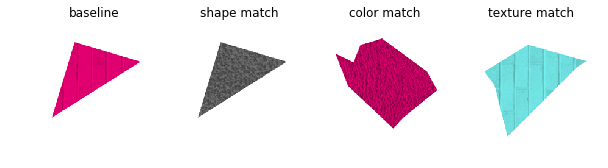

Shape match score: 0.986
Color match score: 0.942
Texture match score: 0.952




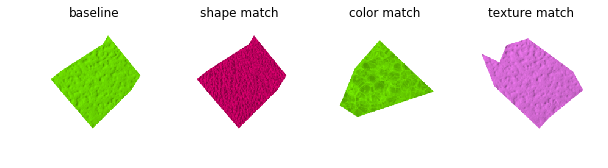

Shape match score: 0.947
Color match score: 0.963
Texture match score: 0.934




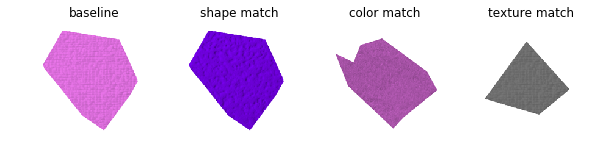

Shape match score: 0.969
Color match score: 0.985
Texture match score: 0.968




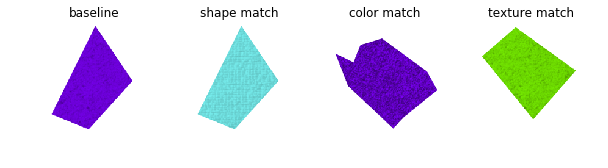

Shape match score: 0.961
Color match score: 0.944
Texture match score: 0.897




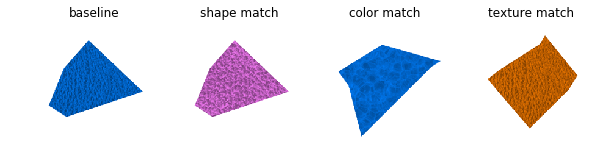

Shape match score: 0.974
Color match score: 0.962
Texture match score: 0.916




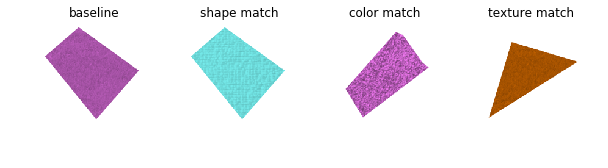

Shape match score: 0.980
Color match score: 0.975
Texture match score: 0.958




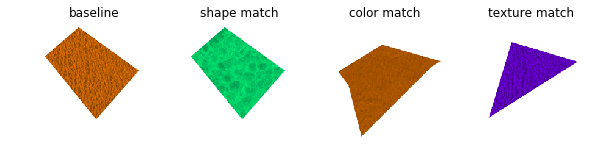

Shape match score: 0.950
Color match score: 0.946
Texture match score: 0.926




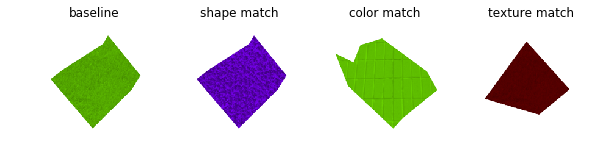

Shape match score: 0.945
Color match score: 0.962
Texture match score: 0.944




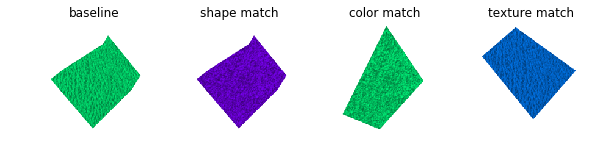

Shape match score: 0.953
Color match score: 0.961
Texture match score: 0.939




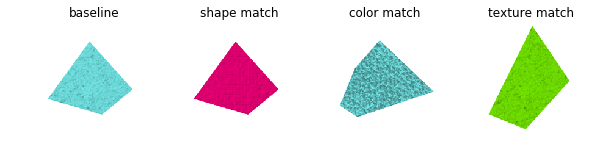

Shape match score: 0.958
Color match score: 0.991
Texture match score: 0.951




In [93]:
for i in range(10):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10,3))
    axes[0].imshow(trial_imgs[i*4])
    axes[0].axis('off')
    axes[0].set_title('baseline')
    axes[1].imshow(trial_imgs[i*4+1])
    axes[1].axis('off')
    axes[1].set_title('shape match')
    axes[2].imshow(trial_imgs[i*4+2])
    axes[2].axis('off')
    axes[2].set_title('color match')
    axes[3].imshow(trial_imgs[i*4+3])
    axes[3].axis('off')
    axes[3].set_title('texture match')
    plt.show()
    print('Shape match score: %0.3f' % similarity(trial_imgs_rgb[i*4], trial_imgs_rgb[i*4+1]))
    print('Color match score: %0.3f' % similarity(trial_imgs_rgb[i*4], trial_imgs_rgb[i*4+2]))
    print('Texture match score: %0.3f' % similarity(trial_imgs_rgb[i*4], trial_imgs_rgb[i*4+3]))
    print('\n')

In [94]:
def evaluate_secondOrder(X_p):
    # Since we have groupings of 4 samples, X should have a length that is a
    # multiple of 4.
    assert len(X_p) % 4 == 0
    nb_trials = len(X_p)/4.
    counts = {0:0, 1:0, 2:0}
    for i in range(int(len(X_p) / 4)):
        score_shape = similarity(X_p[4*i], X_p[4*i+1])
        score_color = similarity(X_p[4*i], X_p[4*i+2])
        score_texture = similarity(X_p[4*i], X_p[4*i+3])
        match = np.argmax([score_shape, score_color, score_texture])
        counts[match] += 1

    # Return the percentage of times we were correct
    return counts[0]/nb_trials, counts[1]/nb_trials, counts[2]/nb_trials

In [101]:
shape_bias, color_bias, texture_bias = evaluate_secondOrder(trial_imgs_rgb)
print('Shape bias: %0.3f' % shape_bias)
print('Color bias: %0.3f' % color_bias)
print('Texture bias: %0.3f' % texture_bias)

Shape bias: 0.598
Color bias: 0.368
Texture bias: 0.034


In [99]:
model = simple_cnn(input_shape=(200,200,3), nb_classes=5)

In [100]:
from learning2learn.util import get_hidden_representations

trial_imgs_hidden = get_hidden_representations(
    model, trial_imgs, layer_num=-4, batch_size=128
)

In [102]:
shape_bias, color_bias, texture_bias = evaluate_secondOrder(trial_imgs_hidden)
print('Shape bias: %0.3f' % shape_bias)
print('Color bias: %0.3f' % color_bias)
print('Texture bias: %0.3f' % texture_bias)

Shape bias: 0.635
Color bias: 0.339
Texture bias: 0.026


In [103]:
def load_textures(data_folder, contrast_factor=1., target_size=(200, 200)):
    # First load the images
    files = [file for file in os.listdir(data_folder) if file.endswith('tiff')]
    files = sorted(files)
    imgs = np.zeros(shape=(len(files),)+target_size+(3,), dtype=np.float32)
    for i, file in enumerate(files):
        img_path = os.path.join(data_folder, file)
        img = image.load_img(img_path, target_size=target_size,
                             interpolation='bicubic')
        img = image.img_to_array(img) / 255.
        img = adjust_contrast(img, contrast_factor)
        imgs[i] = img

    return imgs

In [107]:
texture_imgs = load_textures('../data/textures/')
ix = np.random.choice(range(len(texture_imgs)), 10, replace=False)
texture_imgs = texture_imgs[ix]

In [108]:
def compare2(img1, img2, metric='cosine'):
    sim = similarity(img1.flatten(), img2.flatten(), metric)
    print('Similarity: %0.3f' % sim)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6,2))
    axes[0].imshow(img1)
    axes[0].axis('off')
    axes[1].imshow(img2)
    axes[1].axis('off')
    plt.show()
    
    return sim

Similarity: 1.000


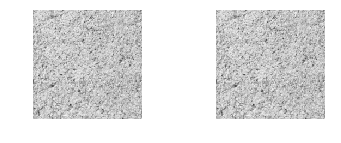

Similarity: 0.989


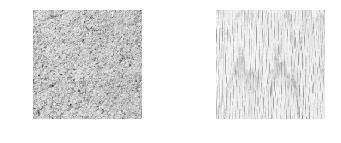

Similarity: 0.893


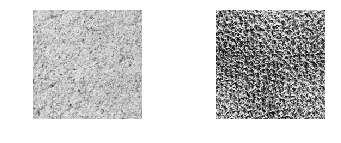

Similarity: 0.901


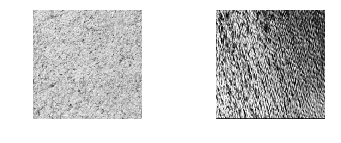

Similarity: 0.963


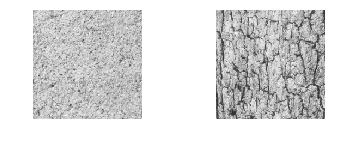

Similarity: 0.889


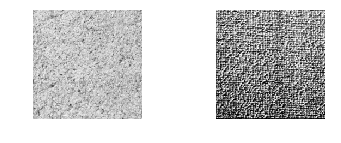

Similarity: 0.975


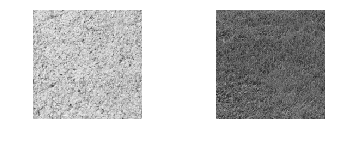

Similarity: 0.963


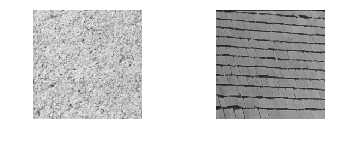

Similarity: 0.988


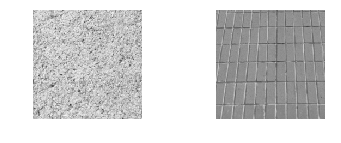

Similarity: 0.900


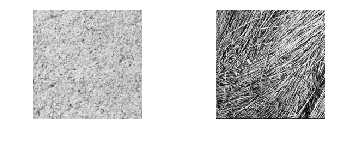

In [109]:
for i in range(len(texture_imgs)):
    compare2(texture_imgs[0], texture_imgs[i])

In [1]:
from __future__ import division

import os
import multiprocessing as mp
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.path as mplpath
from keras.preprocessing import image
import keras.backend as K
from scipy.spatial.distance import cosine, cdist

from learning2learn.util import synthesize_data, get_hidden_representations, shift_image
from learning2learn.images import generate_random_shape
from learning2learn.models import simple_cnn

/home/feinman/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
gpu_options = tf.GPUOptions(allow_growth=True, visible_device_list='1')
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
K.set_session(sess)

In [51]:
def generate_colors():
    nb_colors = 64
    nb_bins = 4
    vals = np.linspace(0, 0.9, nb_bins)
    colors = np.zeros(shape=(nb_colors,3))
    i = 0
    for r in vals:
        for g in vals:
            for b in vals:
                colors[i] = np.asarray([r, g, b])
                i += 1
    
    return colors

def adjust_contrast(img, factor):
    assert factor >= 1.
    img_p = 1. - img
    img_p /= factor
    img_p = 1. - img_p
    
    return img_p

def generate_image(shape, color, texture, target_size=(200, 200), contrast_factor=1.):
    # Generate the base color
    img_color = np.ones(shape=target_size+(3,), dtype=np.float32)*color
    # Generate the base texture
    img_texture = image.load_img(
        '../data/textures/%s' % texture, 
        target_size=target_size, 
        interpolation='bicubic'
    )
    img_texture = image.img_to_array(img_texture) / 255.
    img_texture = img_texture[:,:,0]
    img_texture = adjust_contrast(img_texture, contrast_factor)
    # Put it all together
    img = np.ones(shape=target_size+(4,), dtype=np.float32)
    img[:,:,:3] = img_color
    #img[:,:,3] = img_texture
    # Cutout the shape
    p = mplpath.Path(shape)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if not p.contains_point((i, j)):
                img[j,i,:] = np.ones_like(img[j,i])
    img = shift_image(img, img_size=target_size, scale=20)
    img[:,:,3] = img_texture
                
    return img

def generate_image_wrapper(tup):
    return generate_image(tup[0], tup[1], tup[2])

In [4]:
def make_trial(shape_set, color_set, texture_set, target_size=(200, 200), contrast_factor=1.):
    # randomly select 3 of each feature
    s1, s2, s3 = np.random.choice(range(len(shape_set)), 3, replace=False)
    c1, c2, c3 = np.random.choice(range(len(color_set)), 3, replace=False)
    shape1, shape2, shape3 = shape_set[s1], shape_set[s2], shape_set[s3]
    color1, color2, color3 = color_set[c1], color_set[c2], color_set[c3]
    texture1, texture2, texture3 = np.random.choice(texture_set, 3, replace=False)
    # generate the trial images
    baseline = generate_image(shape1, color1, texture1, target_size, contrast_factor)
    shape_match = generate_image(shape1, color2, texture2, target_size, contrast_factor)
    color_match = generate_image(shape2, color1, texture3, target_size, contrast_factor)
    texture_match = generate_image(shape3, color3, texture1, target_size, contrast_factor)
    
    return np.asarray([baseline, shape_match, color_match, texture_match])

def make_trial_wrapper(tup):
    return make_trial(tup[0], tup[1], tup[2], tup[3], tup[4])

def build_test_trials(shape_set, color_set, texture_set, nb_trials, 
                      target_size=(200, 200), contrast_factor=1.):
    tups = [(shape_set, color_set, texture_set, target_size, contrast_factor)
            for _ in range(nb_trials)]
    p = mp.Pool()
    trials = p.map(make_trial_wrapper, tups)
    
    return np.concatenate(trials)

In [5]:
def train_test_split1(x, test_size):
    step = int(np.ceil(len(x) / test_size)) - 1
    ix = list(range(len(x)))
    ix_test = [i*step for i in range(test_size)]
    ix_train = list(set(ix).difference(ix_test))
    x_train = [x[i] for i in ix_train]
    x_test = [x[i] for i in ix_test]
    
    return x_train, x_test

In [6]:
def compute_area(shape, x_size, y_size):
    area = 0
    p = mplpath.Path(shape)
    for i in range(y_size):
        for j in range(x_size):
            if p.contains_point((i,j)):
                area += 1
                
    return area

def get_secondOrder_data(df_train, nb_test_trials=1000):
    # count the number of categories in the training set
    nb_train = len(np.unique(df_train['shape']))
    # we have 58 textures, so that is our limiting factor
    assert  nb_train < 58
    nb_test = 58 - nb_train
    # get the 58 shapes
    shape_set = [generate_random_shape(0, 200, 0, 200, 40) for _ in range(58)]
    shape_set = sorted(shape_set, key = lambda x: compute_area(x, 200, 200))
    # get the 58 colors
    color_set = generate_colors()
    ix = np.sort(np.random.choice(range(len(color_set)), 58, replace=False))
    color_set = color_set[ix]
    # get the 58 textures
    texture_set = sorted(
        [file for file in os.listdir('../data/textures') if file.endswith('tiff')]
    )
    # perform the train/test splits
    shape_set_train, shape_set_test = train_test_split1(shape_set, test_size=nb_test)
    color_set_train, color_set_test = train_test_split1(color_set, test_size=nb_test)
    texture_set_train, texture_set_test = train_test_split1(texture_set, test_size=nb_test)
    # build the training set of images
    print('Building training set...')
    tups = []
    for i in range(len(df_train)):
        s, c, t = df_train.iloc[i]
        tups.append((shape_set_train[s], color_set_train[c], texture_set_train[t]))
    p = mp.Pool()
    X_train = p.map(generate_image_wrapper, tups)
    p.close()
    p.join()
    X_train = np.asarray(X_train)
    # build the test set trials
    print('Building test trials...')
    X_test = build_test_trials(shape_set_test, color_set_test, texture_set_test, nb_test_trials)
    
    return X_train, X_test

In [52]:
np.random.seed(0)
df_train, labels = synthesize_data(nb_categories=50, nb_exemplars=15)
X_train, X_test = get_secondOrder_data(df_train, nb_test_trials=1000)

Building training set...
Building test trials...


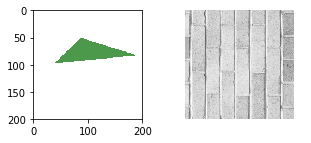

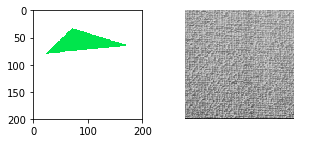

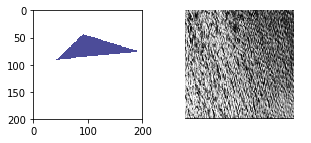

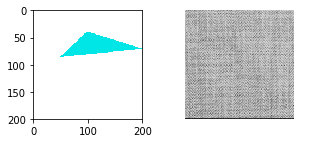

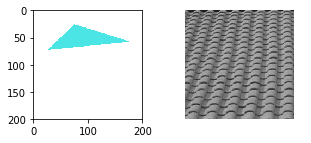

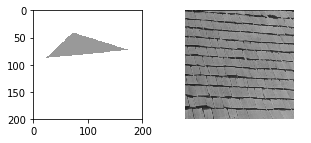

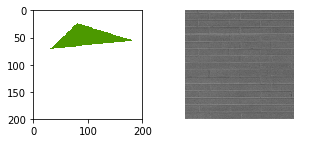

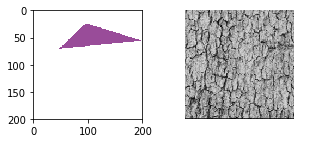

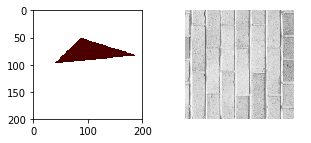

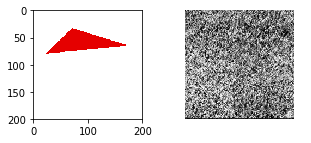

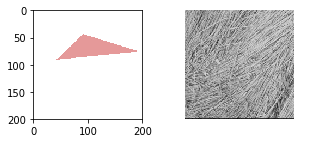

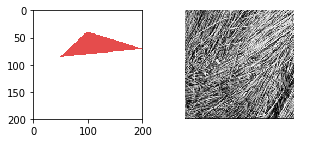

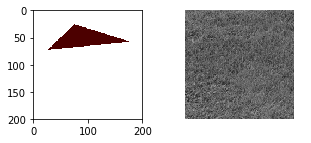

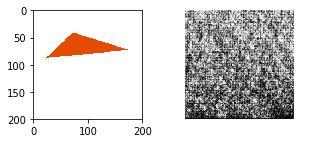

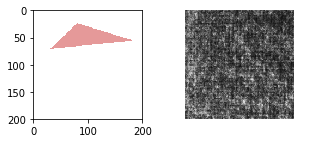

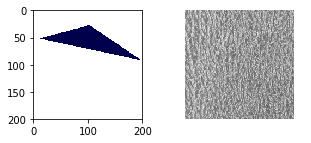

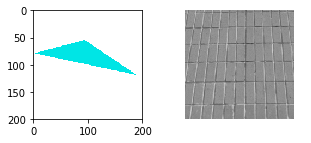

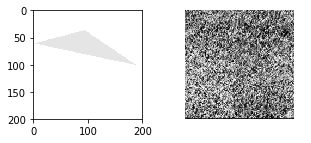

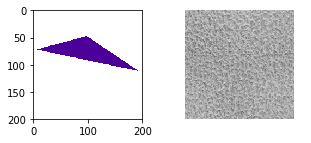

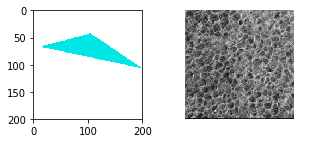

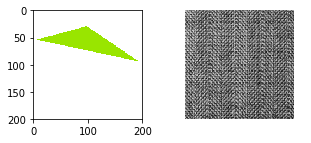

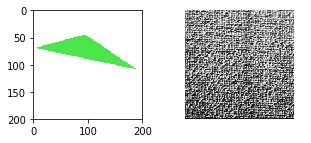

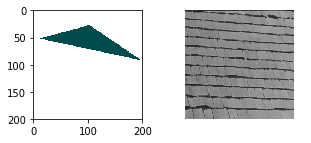

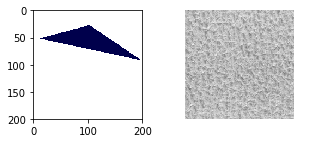

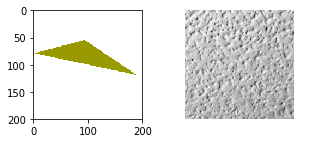

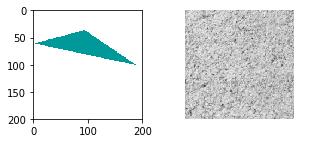

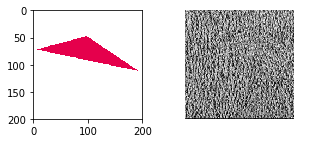

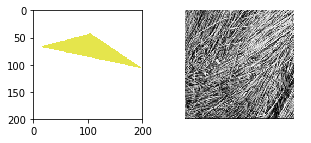

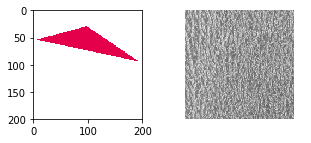

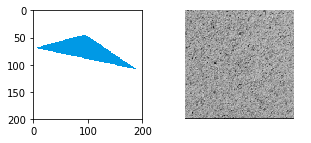

In [37]:
for i in range(30):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5,2))
    axes[0].imshow(X_train[i,:,:,:3], vmin=0., vmax=1.)
    #axes[0].axis('off')
    axes[1].imshow(X_train[i,:,:,3], cmap='gray', vmin=0., vmax=1.)
    axes[1].axis('off')
    plt.show()
    print('\n')

In [14]:
def visualize_trials(imgs, nb_trials):
    for i in range(nb_trials):
        fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12,4))
        # plot colors
        axes[0,0].imshow(imgs[4*i,:,:,:3], vmin=0., vmax=1.)
        #axes[0,0].axis('off')
        axes[0,0].set_title('baseline')
        axes[0,1].imshow(imgs[4*i+1,:,:,:3], vmin=0., vmax=1.)
        #axes[0,1].axis('off')
        axes[0,1].set_title('shape match')
        axes[0,2].imshow(imgs[4*i+2,:,:,:3], vmin=0., vmax=1.)
        #axes[0,2].axis('off')
        axes[0,2].set_title('color match')
        axes[0,3].imshow(imgs[4*i+3,:,:,:3], vmin=0., vmax=1.)
        #axes[0,3].axis('off')
        axes[0,3].set_title('texture match')
        # plot textures
        axes[1,0].imshow(imgs[4*i,:,:,3], cmap='gray', vmin=0., vmax=1.)
        #axes[1,0].axis('off')
        axes[1,1].imshow(imgs[4*i+1,:,:,3], cmap='gray', vmin=0., vmax=1.)
        #axes[1,1].axis('off')
        axes[1,2].imshow(imgs[4*i+2,:,:,3], cmap='gray', vmin=0., vmax=1.)
        #axes[1,2].axis('off')
        axes[1,3].imshow(imgs[4*i+3,:,:,3], cmap='gray', vmin=0., vmax=1.)
        #axes[1,3].axis('off')
        plt.show()
        print('\n\n')

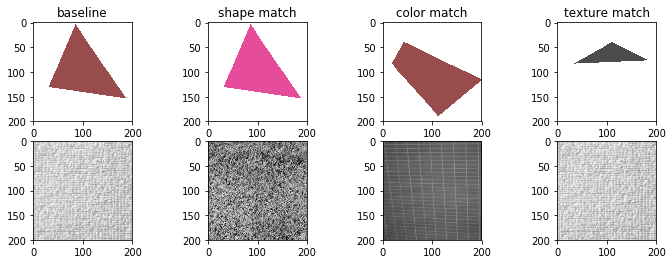

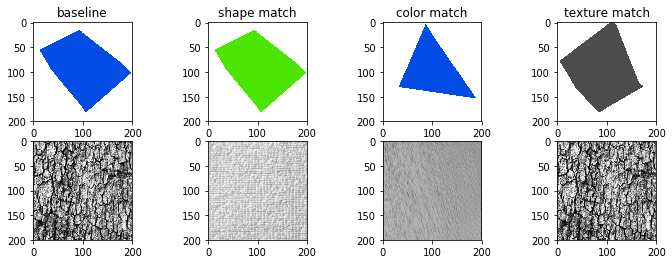

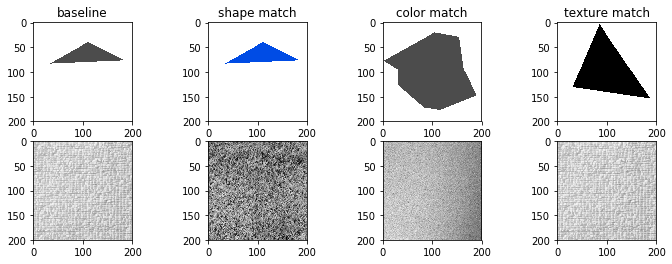

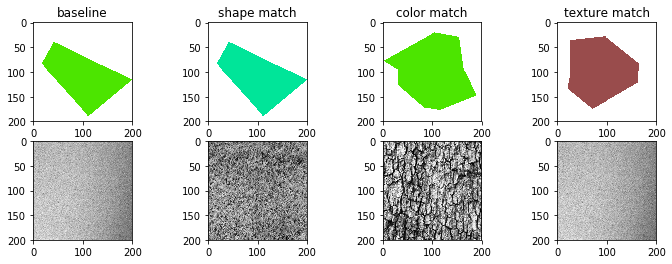

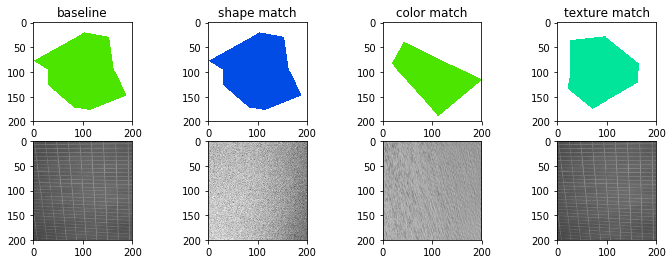

In [42]:
visualize_trials(X_test, 5)

In [16]:
def similarity(x1, x2, measure='cosine'):
    """
    Computes the cosine similarity between two vectors.
    :param x1: (Numpy array) The first vector.
    :param x2: (Numpy array) The second vector.
    :return: (int) The similarity score.
    """
    assert measure in ['cosine', 'euclidean']
    if measure == 'cosine':
        return 1 - cosine(x1, x2)
    else:
        return -np.linalg.norm(x1 - x2)
    
def evaluate_secondOrder(X_p, metric='cosine'):
    # Since we have groupings of 4 samples, X should have a length that is a
    # multiple of 4.
    assert len(X_p) % 4 == 0
    nb_trials = len(X_p)/4.
    counts = {0:0, 1:0, 2:0}
    for i in range(int(nb_trials)):
        score_shape = similarity(X_p[4*i], X_p[4*i+1], metric)
        score_color = similarity(X_p[4*i], X_p[4*i+2], metric)
        score_texture = similarity(X_p[4*i], X_p[4*i+3], metric)
        match = np.argmax([score_shape, score_color, score_texture])
        counts[match] += 1
        # sanity check here because argmax takes first option by default
        if (score_shape == score_color or score_shape == score_texture):
            print(i)

    # Return the percentage of times we were correct
    return counts[0]/nb_trials, counts[1]/nb_trials, counts[2]/nb_trials

In [54]:
tf.set_random_seed(0)
model = simple_cnn(input_shape=(200,200,4), nb_classes=50)

In [43]:
# whole textures no shift
X_test_rgb = X_test.reshape((len(X_test), -1))
shape_bias, color_bias, texture_bias = evaluate_secondOrder(X_test_rgb)
print('Shape bias: %0.3f' % shape_bias)
print('Color bias: %0.3f' % color_bias)
print('Texture bias: %0.3f' % texture_bias)

Shape bias: 0.527
Color bias: 0.449
Texture bias: 0.024


In [55]:
# whole textures w/ shift=20
X_test_rgb = X_test.reshape((len(X_test), -1))
shape_bias, color_bias, texture_bias = evaluate_secondOrder(X_test_rgb)
print('Shape bias: %0.3f' % shape_bias)
print('Color bias: %0.3f' % color_bias)
print('Texture bias: %0.3f' % texture_bias)
print('\n')
X_test_hidden = get_hidden_representations(
    model, X_test, layer_num=-4, batch_size=256
)
shape_bias, color_bias, texture_bias = evaluate_secondOrder(X_test_hidden)
print('Shape bias: %0.3f' % shape_bias)
print('Color bias: %0.3f' % color_bias)
print('Texture bias: %0.3f' % texture_bias)

Shape bias: 0.350
Color bias: 0.363
Texture bias: 0.287


Shape bias: 0.393
Color bias: 0.406
Texture bias: 0.201


In [28]:
# cutout textures
X_test_rgb = X_test.reshape((len(X_test), -1))
shape_bias, color_bias, texture_bias = evaluate_secondOrder(X_test_rgb)
print('Shape bias: %0.3f' % shape_bias)
print('Color bias: %0.3f' % color_bias)
print('Texture bias: %0.3f' % texture_bias)

Shape bias: 0.393
Color bias: 0.516
Texture bias: 0.091


In [29]:
X_test_hidden = get_hidden_representations(
    model, X_test, layer_num=-4, batch_size=256
)

In [30]:
shape_bias, color_bias, texture_bias = evaluate_secondOrder(X_test_hidden)
print('Shape bias: %0.3f' % shape_bias)
print('Color bias: %0.3f' % color_bias)
print('Texture bias: %0.3f' % texture_bias)

Shape bias: 0.388
Color bias: 0.497
Texture bias: 0.115
